<a href="https://colab.research.google.com/github/AntoPrinzi99/NN-project-Antonino-Prinzivalli/blob/main/similarity_of_the_latent_spaces_with_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ComplexCNN(nn.Module):
    def __init__(self):
        super(ComplexCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 256, kernel_size=3, padding='same')
        self.bn1 = nn.BatchNorm2d(256)

        self.conv2 = nn.Conv2d(256, 256, kernel_size=3, padding='same')
        self.bn2 = nn.BatchNorm2d(256)

        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout1 = nn.Dropout(0.2)

        self.conv3 = nn.Conv2d(256, 512, kernel_size=3, padding='same')
        self.bn3 = nn.BatchNorm2d(512)

        self.conv4 = nn.Conv2d(512, 512, kernel_size=3, padding='same')
        self.bn4 = nn.BatchNorm2d(512)

        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout2 = nn.Dropout(0.2)

        self.conv5 = nn.Conv2d(512, 512, kernel_size=3, padding='same')
        self.bn5 = nn.BatchNorm2d(512)

        self.conv6 = nn.Conv2d(512, 512, kernel_size=3, padding='same')
        self.bn6 = nn.BatchNorm2d(512)

        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout3 = nn.Dropout(0.2)

        self.conv7 = nn.Conv2d(512, 512, kernel_size=3, padding='same')
        self.bn7 = nn.BatchNorm2d(512)

        self.conv8 = nn.Conv2d(512, 512, kernel_size=3, padding='same')
        self.bn8 = nn.BatchNorm2d(512)

        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout4 = nn.Dropout(0.2)

        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(512 * 2 * 2, 1024)
        self.dropout5 = nn.Dropout(0.2)
        self.bn9 = nn.BatchNorm1d(1024, momentum=0.95, eps=0.005)
        self.fc2 = nn.Linear(1024, 100)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool1(x)
        x = self.dropout1(x)

        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))
        x = self.pool2(x)
        x = self.dropout2(x)

        x = F.relu(self.bn5(self.conv5(x)))
        x = F.relu(self.bn6(self.conv6(x)))
        x = self.pool3(x)
        x = self.dropout3(x)

        x = F.relu(self.bn7(self.conv7(x)))
        x = F.relu(self.bn8(self.conv8(x)))
        x = self.pool4(x)
        x = self.dropout4(x)

        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = self.dropout5(x)
        x = self.bn9(x)
        x = self.fc2(x)
        return x

    def get_embedding(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool1(x)
        x = self.dropout1(x)

        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))
        x = self.pool2(x)
        x = self.dropout2(x)

        x = F.relu(self.bn5(self.conv5(x)))
        x = F.relu(self.bn6(self.conv6(x)))
        x = self.pool3(x)
        x = self.dropout3(x)

        x = F.relu(self.bn7(self.conv7(x)))
        x = F.relu(self.bn8(self.conv8(x)))
        x = self.pool4(x)
        x = self.dropout4(x)

        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        return x

#Load data

In [ ]:
# Caricamento del dataset CIFAR-100
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761))
])

train_dataset = datasets.CIFAR100(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR100(root='./data', train=False, download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)


  0%|          | 0/169001437 [00:00<?, ?it/s]

Extracting ./data/cifar-100-python.tar.gz to ./data
Files already downloaded and verified


#train

In [ ]:
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.cross_entropy(output, target, reduction='sum').item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    accuracy = correct / len(test_loader.dataset)
    return test_loss, accuracy

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
epochs = [30, 40, 100, 120]
models = []


for epoch in epochs:
    model = ComplexCNN().to(device)
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
    for ep in range(epoch):
        train(model, device, train_loader, optimizer, ep)
    test_loss, accuracy = test(model, device, test_loader)
    models.append((model, accuracy))
    print(f"Model trained for {epoch} epochs: Test loss = {test_loss:.4f}, Accuracy = {accuracy:.4f}")

Model trained for 30 epochs: Test loss = 2.5111, Accuracy = 0.6243
Model trained for 40 epochs: Test loss = 2.4573, Accuracy = 0.6309
Model trained for 100 epochs: Test loss = 2.8325, Accuracy = 0.6552
Model trained for 120 epochs: Test loss = 2.9916, Accuracy = 0.6539


Similarity of Embeddings with the epochs:

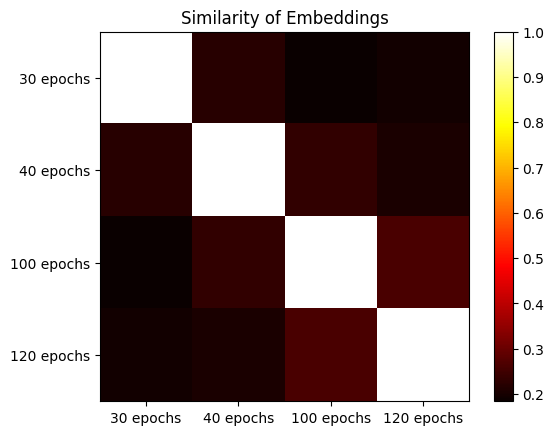

In [ ]:
def get_embeddings(model, device, loader, n_samples=10000):
    model.eval()
    embeddings = []
    with torch.no_grad():
        for i, (data, target) in enumerate(loader):
            data = data.to(device)
            embedding = model.get_embedding(data).cpu().numpy()
            embeddings.append(embedding)
            if i * loader.batch_size >= n_samples:
                break
    return np.concatenate(embeddings)

# Extraction and Averaging of Embeddings
embeddings_list = [get_embeddings(model, device, test_loader).mean(axis=0) for model, _ in models]

# Creation of the similarity matrix
similarities = np.zeros((len(embeddings_list), len(embeddings_list)))

for i in range(len(embeddings_list)):
    for j in range(i, len(embeddings_list)):
        sim = cosine_similarity([embeddings_list[i]], [embeddings_list[j]])[0, 0]
        similarities[i, j] = sim
        similarities[j, i] = sim


plt.imshow(similarities, cmap='hot', interpolation='nearest')
plt.colorbar()
plt.xticks(ticks=np.arange(len(epochs)), labels=[f"{ep} epochs" for ep in epochs])
plt.yticks(ticks=np.arange(len(epochs)), labels=[f"{ep} epochs" for ep in epochs])
plt.title("Similarity of Embeddings")
plt.show()

In [ ]:
#print("Shape of embeddings_list:", np.array(embeddings_list).shape)

Shape of embeddings_list: (4, 1024)


save the models:

In [ ]:
for i, (model, accuracy) in enumerate(models):
    epoch = epochs[i]
    model_path = f"model_epoch_{epoch}.pth"
    torch.save(model.state_dict(), model_path)
    print(f"Model trained for {epoch} epochs with accuracy {accuracy:.4f} saved to {model_path}")

Model trained for 30 epochs with accuracy 0.6243 saved to model_epoch_30.pth
Model trained for 40 epochs with accuracy 0.6309 saved to model_epoch_40.pth
Model trained for 100 epochs with accuracy 0.6552 saved to model_epoch_100.pth
Model trained for 120 epochs with accuracy 0.6539 saved to model_epoch_120.pth
